In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve, curve_fit
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.interpolate import interp1d, interp2d
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.pyplot import cm 

In [2]:
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 20

In [3]:
boltzmann = 1.380658e-16 #cgs
mH = 1.6733000e-24 #grams
mdot = 1.99e33 #grams
G = 6.67259e-8 #cgs
EiCO = 850 #K
EiCO2 = 2000
EiH2O = 5800
mCO = 28*mH
mCO2 = 44*mH
mH2O = 18*mH
Ni = 10**15 #cm^-2 number of sites
au2cm = 1.496e13
nCO = 1.5e-4
nCO2 = 0.3e-4
nH2O = 0.9e-4

In [4]:
boltzmann = 1.380658e-16 #cgs
mH = 1.6733000e-24 #grams
mdot = 1.99e33 #grams
G = 6.67259e-8 #cgs
SB = 5.6704e-5
Ldot = 3.839e33
rsun = 7e10

In [5]:
as209_age = 5.05e13
cytau_age = 6.307e13/2
doar25_age = 6.307e13
drtau_age = 0.9*3.154e13
fttau_age = 2.2*3.154e13
hd163296_age = 1.577e14

mstar_as209 = 0.9*mdot
mstar_cytau = 0.55*mdot
mstar_doar25 = mdot
mstar_drtau = 0.558*mdot
mstar_fttau = 0.298*mdot
mstar_hd163296 = 2.3*mdot

In [6]:
age_def = 3.154e13
mstar_def = mdot

def temp_def(r):
    T = 200 * (r**(-3/7))
    return T
    
def sd_def(r):
    r_c = 40
    gamma = 1 #1.07
    sigma = 375 * ((r/r_c)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))
    #sigma = 375 * r**(-1)
    return sigma

def sd_dust_def(r):
    sigma = 0.01 * sd_def(r)
    return sigma

In [7]:
def temp_as209(r):
    T = 130.765498011*(r**(-3./7))
    return T

def sd_as209(r):
    r_c = 100
    gamma = 1
    sigma = ((r/r_c)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*15
    return sigma

def sd_dust_as209(r):
    r_t = 48
    gamma = 0.91
    sigma_t = 0.81
    sigma = sigma_t*(r/r_t)**(-gamma)*np.exp(-1/(2*(2-gamma))*((r/r_t)**(2-gamma)-1))
    return sigma

In [8]:
def temp_cytau(r):
    T = 89.415006711*(r**(-3./7))
    return T

def sd_cytau(r):
    r_t = 32
    gamma = 0.28
    sigma = ((r_t/r)**(gamma))*np.exp((1-(r/r_t)**(2-gamma))/(2*(2.-gamma)))*20.
    return sigma

def sd_dust_cytau(r): #check
    r_t = 32
    gamma = 0.28
    sigma = ((r_t/r)**(gamma))*np.exp((1-(r/r_t)**(2-gamma))/(2*(2.-gamma)))*11.
    return sigma

In [9]:
def temp_doar25(r):
    T = 123.651629226*(r**(-3./7))
    return T


In [10]:
def temp_drtau(r):
    T = 121.389793367*(r**(-3./7))
    return T

def sd_drtau(r):
    r_c = 20
    gamma = 1.07
    sigma = ((r/40.)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*375
    return sigma

def sd_dust_drtau(r):
    r_c = 20
    gamma = 1.07
    sigma = ((r/40.)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*20
    return sigma

#DR Tau compared to dust -> 16 times more massive than dust

def temp_fttau(r):
    T = 89.0565323094*(r**(-3./7))
    return T

def sd_fttau(r):
    r_c = 28
    gamma = 1.07
    sigma = ((r/40.)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*50.*2.5
    return sigma

def sd_dust_fttau(r):
    r_c = 28
    gamma = 1.07
    sigma = ((r/40.)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*18.
    return sigma

def temp_hd163296(r):
    T = 283.548302503*(r**(-3./7))
    return T

def sd_hd163296(r):
    r_c = 213
    gamma = 0.39
    sigma = ((r/10.)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*110.
    return sigma

def sd_dust_hd163296(r):
    r_c = 118.7
    gamma = 0.882
    sigma = ((r/10.)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*13.4
    return sigma

In [11]:
def tau_s(r,s, T, mstar, rhoGas):
    v_therm = np.sqrt((boltzmann*T)/(2.35*mH))
    rho_part = 2.
    lambda_mfp = 1./((rhoGas/(2.3*mH))*np.pi*10.**-15)
    regime = (9*lambda_mfp)/4.
    t_stop = []
    
    for i,ss in enumerate(s):
        if ss<regime[i]:
            t_stop.append((rho_part*ss)/(rhoGas[i]*v_therm[i]))
        if ss>regime[i]:
            t_stop.append((4*rho_part*ss**2)/(9*rhoGas[i]*v_therm[i]*lambda_mfp[i]))
        
    omega = np.sqrt((G*mstar)/(r*au2cm)**3)
    v_kep = omega*(r*au2cm)
    tau_stop = omega*t_stop
    
    return tau_stop
    

In [12]:
def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

In [13]:
def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st))[0]*st

In [14]:
def d_V_12(st_1,st_2,Re, v_gas):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    
    st_eta = Re**(-0.5)
    
    st_1_str = st_str(st_1)
    st_2_str = st_str(st_2)
    
    st_12_str = max(st_1_str,st_2_str)
    st_12_str = max(st_12_str,st_eta)

    term_1 = (st_12_str + st_1**2./(st_1 + st_12_str) - (st_eta + st_1**2./(st_1 + st_eta))) +\
                ( (st_2 - st_1)/(st_1 + st_2) * (st_1**2./(st_1 + 1.) - st_1**2./(st_1 + st_12_str)) )

    term_2 = (st_12_str + st_2**2./(st_2 + st_12_str) - (st_eta + st_2**2./(st_2 + st_eta))) +\
                ( (st_1 - st_2)/(st_2 + st_1) * (st_2**2./(st_2 + 1.) - st_2**2./(st_2 + st_12_str)) )

    return np.sqrt(v_gas**2*(term_1 + term_2))

In [15]:
def dust_to_gas(disk_name, r, rho_int, alpha):
    
    if disk_name == 'default':
        T = temp_def(r)
        mstar = mstar_def
        time_grow = 0.1 * age_def
        sigma = sd_def(r)
        
    if disk_name == 'as209':
        T = temp_as209(r)
        mstar = mstar_as209
        time_grow = as209_age
        sigma = sd_as209(r)
    
    if disk_name == 'fttau':
        T = temp_fttau(r)
        mstar = mstar_fttau
        time_grow = 0.1 * fttau_age
        sigma = sd_fttau(r)
    
    if disk_name == 'drtau':
        T = temp_drtau(r)
        mstar = mstar_drtau
        time_grow = 0.1 * drtau_age
        sigma = sd_drtau(r)
    
    if disk_name == 'hd163296':
        T = temp_hd163296(r)
        mstar = mstar_hd163296
        time_grow = hd163296_age
        sigma = sd_hd163296(r)
    
    if disk_name == 'cytau':
        T = temp_cytau(r)
        mstar = mstar_cytau
        time_grow = cytau_age
        sigma = sd_cytau(r)
        
    cs = np.sqrt((boltzmann*T)/(2.35*mH))
    omega = np.sqrt((G*mstar)/(r*au2cm)**3.)
    H=cs/omega
    rhoGas = sigma/H
    v_kep = omega*(r*au2cm)
    eta = (cs)**2/(2*(v_kep)**2)
    v0 = eta*v_kep
    
    n_r = len(r)
    #
    # calculate the pressure power-law index
    #
    P = sigma * omega * cs /np.sqrt(2*np.pi)
    
    gamma = np.ones(n_r)
    gamma[1:n_r - 1] = r[1:n_r - 1] / P[1:n_r - 1] * (P[2:n_r] - P[0:n_r - 2]) / (r[2:n_r] - r[0:n_r - 2])
    gamma[0] = gamma[1]
    gamma[-1] = gamma[-2]
    gamma = abs(gamma)
    
    amax = sigma*(r*au2cm)/time_grow/v0/rho_int#/gamma
    #print amax,amax*gamma
    
    '''
    for irr,rr in enumerate(r):
        if rr > 30:
            amax[irr] = amax[irr]/2
        if rr < 30:
            amax[irr] = amax[irr]*2
    '''
    
    #print gamma, radius_array
    
    tau_stop = tau_s(r,amax, T, mstar, rhoGas)
    
    vgas = np.sqrt(alpha*cs**2.)
    lambda_mfp = 1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*cs
    Re = (alpha*cs**2)/(nu*omega)
    deltaV = []
    for idx,t in enumerate(tau_stop):
        deltaV.append(d_V_12(t,t,Re[idx], vgas[idx]))
    
    #fd = (tau_stop*cs**2*gamma)/(r*v_kep*omega) #archive test
    #print fd
    
    #sigma_dust = (amax*np.pi*rho_int*cs**2*gamma)/v_kep**2/2/0.55 #great!
    #fd = sigma_dust/sigma
    
    sigma_dust = (amax*np.pi*rho_int*cs**2)/v_kep**2/2/0.55 #great!
    fd = sigma_dust/sigma
    
    #sigma_dust = (tau_stop*cs**2*sigma)/(v_kep**2)/0.55 #no assumption from Til about stoke's
    #fd = sigma_dust/sigma
    
    H_d = H*np.sqrt((alpha)/(alpha+tau_stop))
    #sigma_dust1 = (amax*rho_int*H_d*tau_stop*cs**2)/(deltaV*r*au2cm*v_kep)/0.55
    ##print sigma_dust/sigma_dust1
    #fd = sigma_dust1/sigma
    
    return fd

In [16]:
rad_array = np.logspace(1,2.5,num=100)
fd_drtau = np.mean(dust_to_gas('drtau', rad_array, 2., 1e-3))
fd_cytau = np.mean(dust_to_gas('cytau', rad_array, 2., 1e-3))
fd_fttau = np.mean(dust_to_gas('fttau', rad_array, 2., 1e-3))
fd_as209 = np.mean(dust_to_gas('as209', rad_array, 2., 1e-3))
fd_hd163296 = np.mean(dust_to_gas('hd163296', rad_array, 2., 1e-3))
fd_def = np.mean(dust_to_gas('default', rad_array, 2., 1e-3))

print(fd_drtau, fd_cytau, fd_fttau, fd_as209, fd_hd163296)
print(fd_def)

0.014839411588259743 0.0013454383374524967 0.008307024220134254 0.0006567882063032557 0.00013156560501923563
0.009976455955821473


In [17]:
alpha = 1e-6
radius_array = np.logspace(0,2.5,num=300) #np.logspace(-1,2.5,num=100) # semi-major axes
fd_def = dust_to_gas('default', radius_array, 2., alpha) # Dust-to-gas ratio for default params
fd_drtau = dust_to_gas('drtau', radius_array, 2., alpha) # Dust-to-gas ratio for DR Tau
fd_fttau = dust_to_gas('fttau', radius_array, 2., alpha) # Dust-to-gas ratio for FT Tau

np.savetxt("def_fd.txt", np.array([radius_array, fd_def]))
np.savetxt("def_sd.txt", np.array([radius_array, sd_def(radius_array), sd_dust_def(radius_array)]))

np.savetxt("drtau_fd.txt", np.array([radius_array, fd_drtau]))
np.savetxt("fttau_fd.txt", np.array([radius_array, fd_fttau]))
np.savetxt("drtau_sd.txt", np.array([radius_array, sd_drtau(radius_array), sd_dust_drtau(radius_array)]))
np.savetxt("fttau_sd.txt", np.array([radius_array, sd_fttau(radius_array), sd_dust_fttau(radius_array)]))

# M_star, T_0, Sig_0, R_crit, alpha, t_disk
np.savetxt("def_params.txt", np.array([mstar_def/mdot, 121.389793367, 375, 40, alpha, age_def]))
np.savetxt("drtau_params.txt", np.array([mstar_drtau/mdot, 121.389793367, 375, 40, alpha, drtau_age]))
np.savetxt("fttau_params.txt", np.array([mstar_fttau/mdot, 89.0565323094, 125, 40, alpha, fttau_age]))

In [18]:
rad_til,sigd_til = np.loadtxt('til_sigma_dust.txt', unpack=True) # DR Tau
rad_til_ft,sigd_til_ft = np.loadtxt('fttau_tildust.txt', unpack=True) # FT Tau

Text(0, 0.5, 'fd')

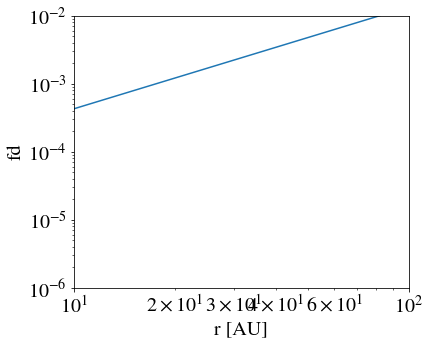

In [19]:
plt.loglog(radius_array,fd_drtau)
plt.xlim(10,100)
plt.ylim(1e-6,1e-2)
plt.xlabel(r'r [AU]')
plt.ylabel(r'fd')

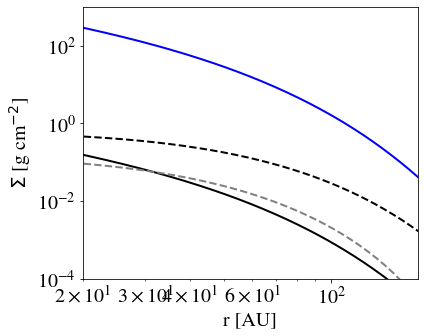

In [20]:
plt.loglog(radius_array, sd_drtau(radius_array), lw=2, c='blue')
plt.loglog(radius_array, sd_dust_drtau(radius_array)/100, lw=2, c='k')
plt.plot(radius_array, fd_drtau*sd_drtau(radius_array)+(0.3*fd_drtau*sd_drtau(radius_array)), lw=2, c='k', ls='--')
plt.plot(rad_til, sigd_til, lw=2, c='gray', ls='--')
plt.xlim(20,175)
plt.ylim(1e-4,1e3)
plt.xlabel(r'r [AU]')
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]')
plt.savefig('drtau_sd_comp.pdf', type='pdf', bbox_inches='tight')

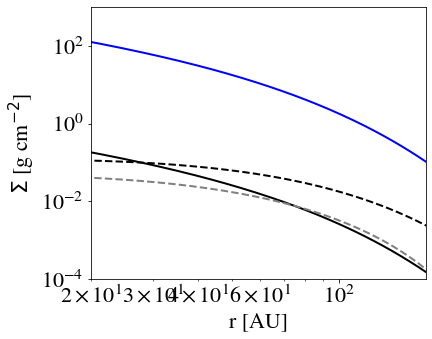

In [21]:
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 22

plt.loglog(radius_array, sd_fttau(radius_array), lw=2, c='blue')
plt.loglog(radius_array, sd_dust_fttau(radius_array)/100, lw=2, c='k')
plt.plot(radius_array, fd_fttau*sd_fttau(radius_array)+(0.3*fd_fttau*sd_fttau(radius_array)), lw=2, c='k', ls='--')
plt.plot(rad_til_ft, sigd_til_ft, lw=2, c='gray', ls='--')
plt.xlim(20,175)
plt.ylim(1e-4,1e3)
plt.xlabel(r'r [AU]')
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]')
plt.savefig('fttau_sd_comp.pdf', type='pdf', bbox_inches='tight')

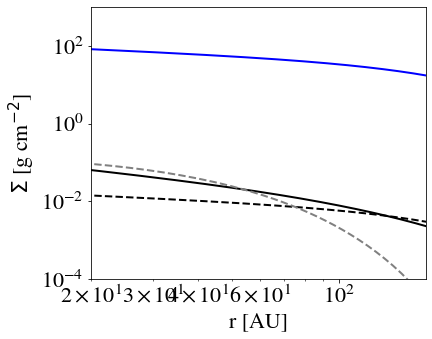

In [22]:
plt.loglog(radius_array, sd_hd163296(radius_array), lw=2, c='blue')
plt.loglog(radius_array, sd_dust_hd163296(radius_array)/100, lw=2, c='k')
plt.plot(radius_array, fd_hd163296*sd_hd163296(radius_array)+(0.3*fd_hd163296*sd_hd163296(radius_array)), lw=2, c='k', ls='--')
plt.plot(rad_til, sigd_til, lw=2, c='gray', ls='--')
plt.xlim(20,175)
plt.ylim(1e-4,1e3)
plt.xlabel(r'r [AU]')
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]')
plt.savefig('drtau_sd_comp.pdf', type='pdf', bbox_inches='tight')

In [23]:
def gamma(disk_name, r, rho_int, alpha):
    
    if disk_name == 'as209':
        T = temp_as209(r)
        mstar = mstar_as209
        time_grow = as209_age
        sigma = sd_as209(r)
    
    if disk_name == 'fttau':
        T = temp_fttau(r)
        mstar = mstar_fttau
        time_grow = fttau_age
        sigma = sd_fttau(r)
    
    if disk_name == 'drtau':
        T = temp_drtau(r)
        mstar = mstar_drtau
        time_grow = drtau_age
        sigma = sd_drtau(r)
    
    if disk_name == 'hd163296':
        T = temp_hd163296(r)
        mstar = mstar_hd163296
        time_grow = hd163296_age
        sigma = sd_hd163296(r)
    
    if disk_name == 'cytau':
        T = temp_cytau(r)
        mstar = mstar_cytau
        time_grow = cytau_age
        sigma = sd_cytau(r)
        
    cs = np.sqrt((boltzmann*T)/(2.35*mH))
    omega = np.sqrt((G*mstar)/(r*au2cm)**3.)
    H=cs/omega
    rhoGas = sigma/H
    v_kep = omega*(r*au2cm)
    eta = (cs)**2/(2*(v_kep)**2)
    v0 = eta*v_kep
    
    n_r = len(r)
    #
    # calculate the pressure power-law index
    #
    P = sigma * omega * cs /np.sqrt(2*np.pi)
    gamma = np.zeros(n_r)
    gamma[1:n_r - 1] = r[1:n_r - 1] / P[1:n_r - 1] * (P[2:n_r] - P[0:n_r - 2]) / (r[2:n_r] - r[0:n_r - 2])
    gamma[0] = gamma[1]
    gamma[-1] = gamma[-2]
    gamma = abs(gamma)
    
    
    return gamma

In [24]:
gamdrtau = gamma('as209', radius_array, 2., 1e-3)

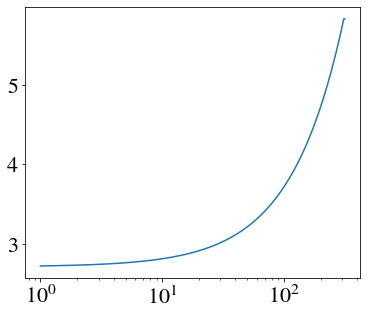

In [25]:
plt.plot(radius_array,gamdrtau)
plt.xscale('log')

In [26]:
print(np.pi/(2*0.55))

2.855993321445266


## MMSN Calculation

In [26]:
# Using parameters from Desch (2007)
mmsn_age = 3.1536e13 # 1 Myr
mstar_mmsn = mdot

alpha_mmsn = 4e-4

def temp_mmsn(r):
    T = 150*(r**(-3./7))
    return T

def sd_mmsn(r):
    r_c = 10
    gamma = 2.168
    sigma = 343 * (r/r_c)**(-gamma) #((r/r_c)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))*15
    return sigma

#def sd_dust_mmsn(r):
#    r_t = 48
#    gamma = 0.91
#    sigma_t = 0.81
#    sigma = sigma_t*(r/r_t)**(-gamma)*np.exp(-1/(2*(2-gamma))*((r/r_t)**(2-gamma)-1))
#    return sigma

In [27]:
def dust_to_gas(disk_name, r, rho_int, alpha):
    
    if disk_name == 'as209':
        T = temp_as209(r)
        mstar = mstar_as209
        time_grow = as209_age
        sigma = sd_as209(r)
    
    if disk_name == 'fttau':
        T = temp_fttau(r)
        mstar = mstar_fttau
        time_grow = fttau_age
        sigma = sd_fttau(r)
    
    if disk_name == 'drtau':
        T = temp_drtau(r)
        mstar = mstar_drtau
        time_grow = drtau_age
        sigma = sd_drtau(r)
    
    if disk_name == 'hd163296':
        T = temp_hd163296(r)
        mstar = mstar_hd163296
        time_grow = hd163296_age
        sigma = sd_hd163296(r)
    
    if disk_name == 'cytau':
        T = temp_cytau(r)
        mstar = mstar_cytau
        time_grow = cytau_age
        sigma = sd_cytau(r)
    
    if disk_name == 'mmsn':
        T = temp_mmsn(r)
        mstar = mstar_mmsn
        time_grow = mmsn_age
        sigma = sd_mmsn(r)
        
    cs = np.sqrt((boltzmann*T)/(2.35*mH))
    omega = np.sqrt((G*mstar)/(r*au2cm)**3.)
    H=cs/omega
    rhoGas = sigma/H
    v_kep = omega*(r*au2cm)
    eta = (cs)**2/(2*(v_kep)**2)
    v0 = eta*v_kep
    
    n_r = len(r)
    #
    # calculate the pressure power-law index
    #
    P = sigma * omega * cs /np.sqrt(2*np.pi)
    
    gamma = np.ones(n_r)
    gamma[1:n_r - 1] = r[1:n_r - 1] / P[1:n_r - 1] * (P[2:n_r] - P[0:n_r - 2]) / (r[2:n_r] - r[0:n_r - 2])
    gamma[0] = gamma[1]
    gamma[-1] = gamma[-2]
    gamma = abs(gamma)
    
    amax = sigma*(r*au2cm)/time_grow/v0/rho_int#/gamma
    #print amax,amax*gamma
    
    '''
    for irr,rr in enumerate(r):
        if rr > 30:
            amax[irr] = amax[irr]/2
        if rr < 30:
            amax[irr] = amax[irr]*2
    '''
    
    #print gamma, radius_array
    
    tau_stop = tau_s(r,amax, T, mstar, rhoGas)
    
    vgas = np.sqrt(alpha*cs**2.)
    lambda_mfp = 1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*cs
    Re = (alpha*cs**2)/(nu*omega)
    deltaV = []
    for idx,t in enumerate(tau_stop):
        deltaV.append(d_V_12(t,t,Re[idx], vgas[idx]))
    
    #fd = (tau_stop*cs**2*gamma)/(r*v_kep*omega) #archive test
    #print fd
    
    #sigma_dust = (amax*np.pi*rho_int*cs**2*gamma)/v_kep**2/2/0.55 #great!
    #fd = sigma_dust/sigma
    
    sigma_dust = (amax*np.pi*rho_int*cs**2)/v_kep**2/2/0.55 #great!
    fd = sigma_dust/sigma
    
    #sigma_dust = (tau_stop*cs**2*sigma)/(v_kep**2)/0.55 #no assumption from Til about stoke's
    #fd = sigma_dust/sigma
    
    H_d = H*np.sqrt((alpha)/(alpha+tau_stop))
    #sigma_dust1 = (amax*rho_int*H_d*tau_stop*cs**2)/(deltaV*r*au2cm*v_kep)/0.55
    ##print sigma_dust/sigma_dust1
    #fd = sigma_dust1/sigma
    
    return fd

In [28]:
rad_array = np.logspace(1,2.5,num=100)
fd_mmsn = np.mean(dust_to_gas('mmsn', rad_array, 2., 1e-3))

print(fd_mmsn)

0.0009977721361193847


In [29]:
alpha = alpha_mmsn
radius_array = np.logspace(0,2.5,num=300) #np.logspace(-1,2.5,num=100) # semi-major axes
fd_mmsn = dust_to_gas('mmsn', radius_array, 2., alpha) # Dust-to-gas ratio for MMSN

np.savetxt("mmsn_fd.txt", np.array([radius_array, fd_mmsn]))
np.savetxt("mmsn_sd.txt", np.array([radius_array, sd_mmsn(radius_array), fd_mmsn*sd_mmsn(radius_array)]))

# M_star, T_0, Sig_0, R_crit, alpha, t_disk
np.savetxt("mmsn_params.txt", np.array([mstar_mmsn/mdot, 150, 343, 10, alpha, mmsn_age]))